In [9]:
# 3rd Method — LSTM (Deep Learning)
%pip install --upgrade mido numpy pandas matplotlib enlighten scikit-learn seaborn tensorflow

import mido
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import enlighten
import seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam

# Load metadata
df = pd.read_csv("maestro-v3.0.0/maestro-v3.0.0.csv")

# Add metadata column for absolute file paths
df["midi_path"] = df["midi_filename"].apply(
    lambda p: Path("maestro-v3.0.0") / p
)

# Split data (Same as KNN)
df_train = df[df["split"].isin(["train", "validation"])]
df_test = df[df["split"] == "test"]

FPS = 20
ACTIVE_THRESHOLD = 64
SEQ_LENGTH = 50  # LSTM needs context: 50 frames @ 20FPS = 2.5 seconds history
BATCH_SIZE = 64


#####--------------------#####
# Reused Helper Methods
#####--------------------#####

def extract_pedal(midi):
    curve = []
    time_s = 0
    for msg in midi:
        time_s += msg.time
        if msg.type == "control_change" and msg.control == 64:
            curve.append((time_s, msg.value))
    return curve


def pedal_to_binary(values, active_threshold=ACTIVE_THRESHOLD):
    values = np.asarray(values)
    return (values > active_threshold).astype(int)


def resample_curve(times, values, fps=FPS, fill_value=0):
    """
    Standard 1D resampling (used for pedal).
    """
    times = np.asarray(times)
    values = np.asarray(values)

    if len(times) == 0:
        return np.array([]), np.array([])

    t_end = times[-1]
    t_grid = np.arange(0, t_end, 1.0 / fps)

    idx = np.searchsorted(times, t_grid, side="right") - 1
    idx[idx < 0] = 0

    return t_grid, values[idx]


#####--------------------#####
# New Helpers for Raw Data (Piano Roll)
#####--------------------#####

def midi_to_pianoroll(midi, fps=FPS):
    """
    Converts MIDI to a Piano Roll array (Time x 88).
    This represents 'Raw Data' with no feature engineering.
    """
    # 1. Calculate total duration
    total_time = 0
    for msg in midi:
        total_time += msg.time

    # 2. Create Time Grid
    n_steps = int(np.ceil(total_time * fps))
    # Shape: [Time, 88 keys] (MIDI notes 21 to 108)
    pianoroll = np.zeros((n_steps, 88), dtype=np.float32)

    # 3. Paint notes onto the grid
    current_time = 0
    active_notes = set()  # Stores pitch

    # We iterate messages and "fill" the grid between events
    for msg in midi:
        dt = msg.time

        # Calculate start and end indices in the grid for this time delta
        start_idx = int(np.round(current_time * fps))
        end_idx = int(np.round((current_time + dt) * fps))

        # Fill the grid for the duration of dt with currently held notes
        if end_idx > start_idx:
            # Clip end_idx to prevent overflow
            end_idx = min(end_idx, n_steps)
            for note in active_notes:
                if 21 <= note <= 108:
                    pianoroll[start_idx:end_idx, note - 21] = 1.0

        current_time += dt

        # Update active notes state
        if msg.type == 'note_on' and msg.velocity > 0:
            active_notes.add(msg.note)
        elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
            if msg.note in active_notes:
                active_notes.remove(msg.note)

    return pianoroll


def create_sequences(X, y, seq_length=SEQ_LENGTH):
    """
    Splits continuous data into sequences for the LSTM.
    Returns: (Num_Sequences, Seq_Length, Features)
    """
    Xs, ys = [], []
    # Create non-overlapping sequences for training efficiency
    for i in range(0, len(X) - seq_length, seq_length):
        Xs.append(X[i: i + seq_length])
        ys.append(y[i: i + seq_length])

    return np.array(Xs), np.array(ys)


#####--------------------#####
# Model Definition
#####--------------------#####

def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        # Return sequences=True so we output a prediction for every time step
        LSTM(64, return_sequences=True, activation='tanh'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary output (Pedal On/Off)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


#####--------------------#####
# Prediction & Eval Logic
#####--------------------#####

def predict_pedal_lstm(midi_path, model):
    midi = mido.MidiFile(midi_path)

    # Get raw inputs (Piano Roll)
    X_raw = midi_to_pianoroll(midi)

    # Reshape for LSTM: [1, Total_Time, 88]
    # We feed the whole song as one giant batch/sequence for inference
    X_in = X_raw[np.newaxis, :, :]

    # Predict
    y_pred = model.predict(X_in, verbose=0)

    # Flatten back to 1D array
    y_pred_flat = y_pred.flatten()

    # Generate time grid matching the input
    t_grid = np.arange(len(y_pred_flat)) / FPS

    # Binarize output
    y_pred_binary = (y_pred_flat > 0.5).astype(int)

    return t_grid, y_pred_binary

Note: you may need to restart the kernel to use updated packages.


In [10]:
# --- 1. Prepare Training Data for LSTM ---
X_sequences = []
y_sequences = []

manager = enlighten.get_manager()
pbar = manager.counter(total=len(df_train), desc='Preprocessing MIDI', unit='file')

for _, row in df_train.iterrows():
    try:
        midi = mido.MidiFile(row["midi_path"])

        # 1. Get Inputs (Piano Roll)
        X_roll = midi_to_pianoroll(midi)

        # 2. Get Targets (Pedal)
        pedal_curve = extract_pedal(midi)
        if not pedal_curve:
            continue

        p_times, p_vals = zip(*pedal_curve)
        p_binary = pedal_to_binary(p_vals)

        # We must align the pedal target exactly to the piano roll grid
        # The piano roll is generated at strictly FPS, so we resample pedal to same grid
        t_end_roll = len(X_roll) / FPS
        t_grid_pedal, p_resampled = resample_curve(p_times, p_binary)

        # Trim or Pad to match lengths
        min_len = min(len(X_roll), len(p_resampled))
        X_roll = X_roll[:min_len]
        p_resampled = p_resampled[:min_len]

        # 3. Create Sequences
        # We chunk the song into segments of SEQ_LENGTH
        if min_len > SEQ_LENGTH:
            xs, ys = create_sequences(X_roll, p_resampled)
            X_sequences.append(xs)
            y_sequences.append(ys)

    except Exception as e:
        print(f"Error processing {row['midi_path']}: {e}")
        continue

    pbar.update()

manager.stop()

In [11]:
# Stack all sequences from all files
if X_sequences:
    X_train = np.vstack(X_sequences)
    y_train = np.vstack(y_sequences)
    # y_train needs to be (N, Seq_Len, 1)
    y_train = y_train[..., np.newaxis]

    print(f"Training Data Shape: {X_train.shape}")
    print(f"Target Data Shape: {y_train.shape}")
else:
    print("No data processed.")

Training Data Shape: (255851, 50, 88)
Target Data Shape: (255851, 50, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, None, 64)       │        39,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, None, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,281 (161.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
3598/3598 ━━━━━━━━━━━━━━━━━━━━ 73s 19ms/step - accuracy: 0.6760 - loss: 0.5943 - val_accuracy: 0.6785 - val_loss: 0.5953
Epoch 2/5
3598/3598 ━━━━━━━━━━━━━━━━━━━━ 68s 19ms/step - accuracy: 0.7000 - loss: 0.5658 - val_accuracy: 0.6863 - val_loss: 0.5831
Epoch 3/5
3598/3598 ━━━━━━━━━━━━━━━━━━━━ 76s 21ms/step - accuracy: 0.7101 - loss: 0.5531 - val_accuracy: 0.6898 - val_loss: 0.5791
Epoch 4/5
3598/3598 ━━━━━━━━━━━━━━━━━━━━ 85s 24ms/step - accuracy: 0.7170 - loss: 0.5442 - val_accuracy: 0.6920 - val_loss: 0.5776
Epoch 5/5
3598/3598 ━━━━━━━━━━━━━━━━━━━━ 68s 19ms/step - accuracy: 0.7225 - loss: 0.5366 - val_accuracy: 0.6931 - val_loss: 0.5783


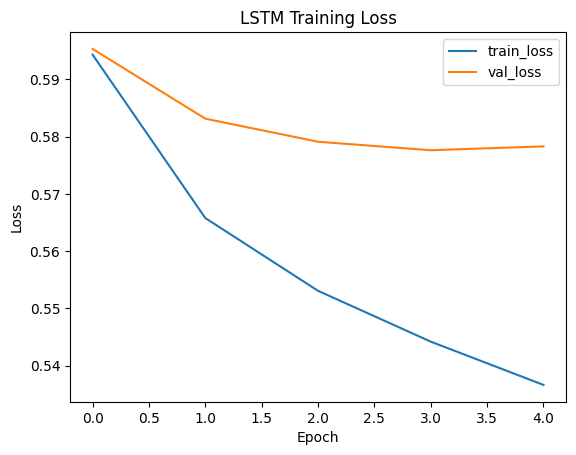

In [12]:
# --- 2. Train LSTM ---
model = None

if len(X_sequences) > 0:
    # Shape: (Sequence_Length, 88 Features)
    input_shape = (None, 88)

    model = build_lstm_model(input_shape)
    model.summary()

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=5,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    # Plot training history
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('LSTM Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Visualizing: maestro-v3.0.0\2014\MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--4.midi


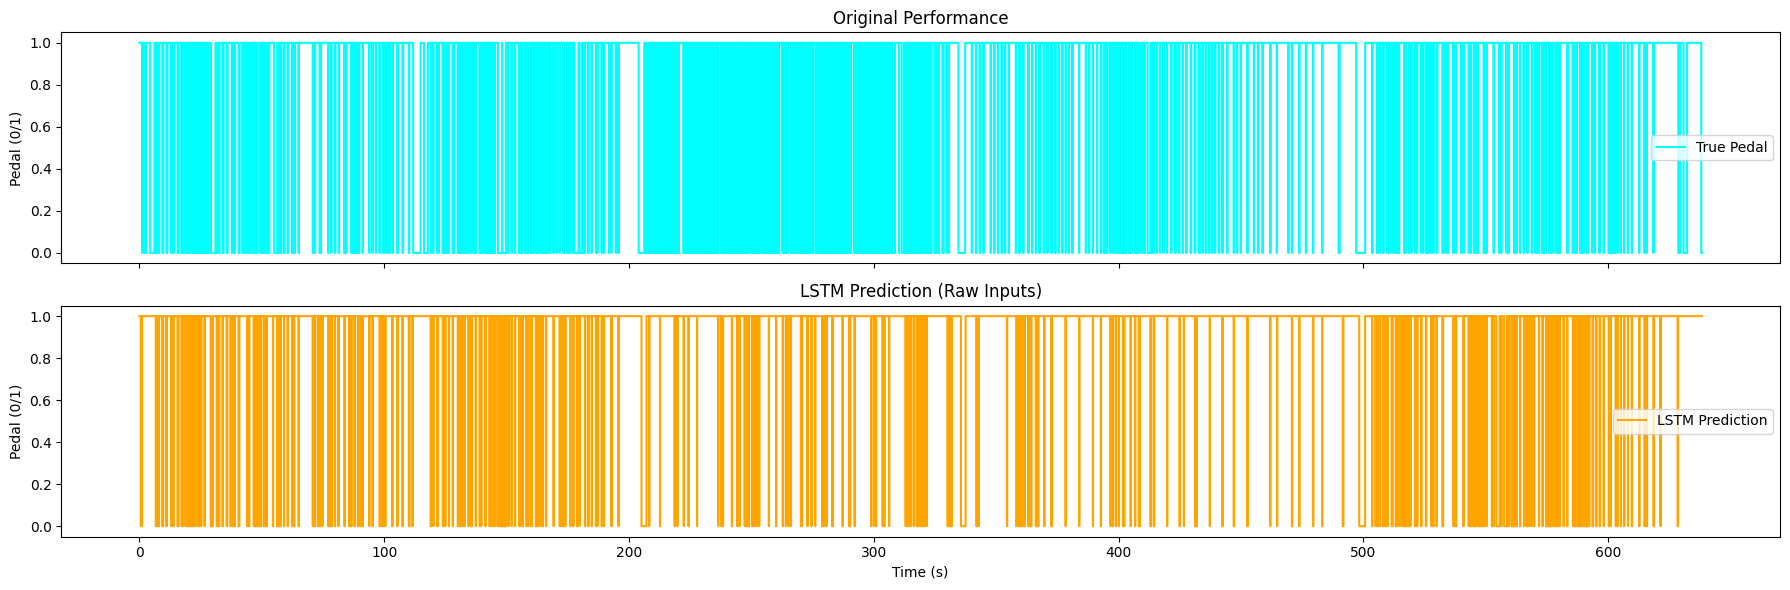

In [20]:
## Sampling
if model is not None:
    sample_row = df_test.iloc[150]
    sample_path = sample_row["midi_path"]

    print(f"Visualizing: {sample_path}")

    # Predict
    t_grid_pred, y_pred = predict_pedal_lstm(sample_path, model)

    # Get True Data for comparison
    midi_true = mido.MidiFile(sample_path)
    p_curve = extract_pedal(midi_true)
    p_times, p_vals = zip(*p_curve)
    p_bin = pedal_to_binary(p_vals)

    # Visualization
    fig, axs = plt.subplots(2, 1, figsize=(18, 6), sharex=True)

    # Plot True
    axs[0].step(p_times, p_bin, where='post', color='cyan', label='True Pedal')
    axs[0].set_title("Original Performance")
    axs[0].set_ylabel("Pedal (0/1)")
    axs[0].legend()

    # Plot Predicted
    axs[1].step(t_grid_pred, y_pred, where='post', color='orange', label='LSTM Prediction')
    axs[1].set_title("LSTM Prediction (Raw Inputs)")
    axs[1].set_ylabel("Pedal (0/1)")
    axs[1].set_xlabel("Time (s)")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [14]:
## Evaluation
def evaluate_lstm_all(df_test, model):
    y_true_all = []
    y_pred_all = []

    for _, row in df_test.iterrows():
        midi_path = row["midi_path"]

        # Get Ground Truth
        midi = mido.MidiFile(midi_path)
        ped_curve = extract_pedal(midi)
        if not ped_curve: continue

        p_t, p_v = zip(*ped_curve)
        p_bin = pedal_to_binary(p_v)

        # Get Prediction
        t_pred, y_p = predict_pedal_lstm(midi_path, model)

        # Align Ground Truth to Prediction Grid
        # We assume t_pred is the authoritative FPS grid
        _, p_true_resampled = resample_curve(p_t, p_bin, fps=FPS)

        # Truncate to match length (alignment issues can happen at the very end due to rounding)
        min_len = min(len(y_p), len(p_true_resampled))

        y_true_all.extend(p_true_resampled[:min_len])
        y_pred_all.extend(y_p[:min_len])

    return confusion_matrix(y_true_all, y_pred_all)

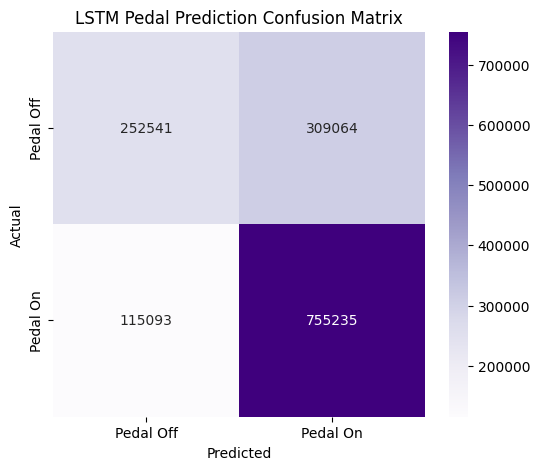

In [15]:
if model is not None:
    cm = evaluate_lstm_all(df_test, model)
    class_labels = ["Pedal Off", "Pedal On"]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("LSTM Pedal Prediction Confusion Matrix")
    plt.show()